# F team

김상화, 박진영, 조재영, 최은지

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import copy
import warnings
import seaborn as sns
warnings.filterwarnings('ignore')
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import Adam, Adamax, Adagrad

seed = 0
np.random.seed(seed)

In [33]:
data = pd.read_csv("./dataset/bike_sharing_demand_train.csv")
submission = pd.read_csv("./dataset/sampleSubmission.csv")
test = pd.read_csv("./dataset/test.csv")

In [34]:
def rmsle(y, pred):
    log_y = np.log1p(y)
    log_pred = np.log1p(pred)
    squared_error = (log_y - log_pred) ** 2
    rmsle = np.sqrt(np.mean(squared_error))
    print('RMSLE: {0:.4f}'.format(rmsle))
    return rmsle

# 1. 데이터 이해

## (1) 훈련용 데이터에는 존재하지만 테스트 데이터에는 존재하지 않는 columns 확인

In [35]:
x = [x for x in data.columns.tolist()]
y = [y for y in test.columns.tolist()]
for i in x:
    if(i not in y):
        print(i)

casual
registered
count


- casual + registered = counts 라는 것을 확인했고, 실제 예측 시 불필요한 column임을 확인하여 삭제

In [36]:
data.drop(['casual','registered'],axis = 1,inplace = True)

## (2) datetime column을 year, month, day, hour column 으로 변경

In [37]:
data['datetime'] = data['datetime'].astype("datetime64")
data['year'] = data['datetime'].dt.year
data['month'] = data['datetime'].dt.month
data['day'] = data['datetime'].dt.day
data['hour'] = data['datetime'].dt.hour

test['datetime'] = test['datetime'].astype("datetime64")
test['year'] = test['datetime'].dt.year
test['month'] = test['datetime'].dt.month
test['day'] = test['datetime'].dt.day
test['hour'] = test['datetime'].dt.hour

In [38]:
print("훈련용 데이터 : ",data['day'].unique().tolist())
print("테스트 데이터 : ", test['day'].unique().tolist())

훈련용 데이터 :  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
테스트 데이터 :  [20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]


- train 데이터를 월별 1~19일 자전거 이용량 데이터
- test 데이터를 월별 20~31일 자전거 이용량 데이터

In [39]:
# 이미 전처리 과정을 마친 datetime과 예측을 위한 입력값이 달라 불필요한 day는 삭제
data.drop(['datetime','day'],axis = 1,inplace = True)
test.drop(['datetime','day'],axis = 1,inplace = True)

## (3) 종속 변수, 독립 변수 파악

In [40]:
data = pd.concat([data.drop(['count'], axis = 1),data['count']], axis = 1)
data

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,year,month,hour,count
0,1,0,0,1,9.84,14.395,81,0.0000,2011,1,0,16
1,1,0,0,1,9.02,13.635,80,0.0000,2011,1,1,40
2,1,0,0,1,9.02,13.635,80,0.0000,2011,1,2,32
3,1,0,0,1,9.84,14.395,75,0.0000,2011,1,3,13
4,1,0,0,1,9.84,14.395,75,0.0000,2011,1,4,1
...,...,...,...,...,...,...,...,...,...,...,...,...
10881,4,0,1,1,15.58,19.695,50,26.0027,2012,12,19,336
10882,4,0,1,1,14.76,17.425,57,15.0013,2012,12,20,241
10883,4,0,1,1,13.94,15.910,61,15.0013,2012,12,21,168
10884,4,0,1,1,13.94,17.425,61,6.0032,2012,12,22,129


### 독립 변수
- datetime
- season
- holiday
- workingday
- weather
- temp
- atemp
- humidity
- windspeed

### 종속 변수
- count
　
 　
  

　
 　
  
# 2. 데이터 분포 살펴보기

## (1) 전체 데이터 분포를 살펴보기 위해 train, test 데이터를 concat 후 확인

In [41]:
all_data = pd.concat([data.drop(['count'], axis = 1), test], axis = 0)
all_data.reset_index(drop= True,inplace = True)

## (2) 데이터 nan 값 조회

In [42]:
all_data.isna().sum()

season        0
holiday       0
workingday    0
weather       0
temp          0
atemp         0
humidity      0
windspeed     0
year          0
month         0
hour          0
dtype: int64

array([[<AxesSubplot:title={'center':'season'}>,
        <AxesSubplot:title={'center':'weather'}>],
       [<AxesSubplot:title={'center':'year'}>,
        <AxesSubplot:title={'center':'hour'}>],
       [<AxesSubplot:title={'center':'workingday'}>,
        <AxesSubplot:title={'center':'holiday'}>]], dtype=object)

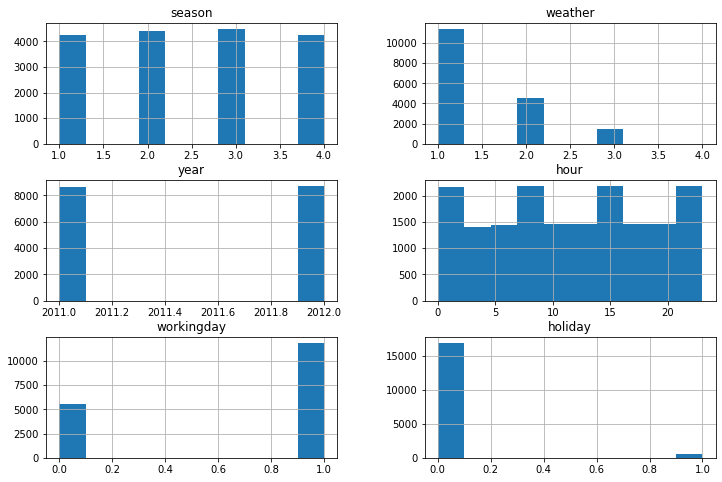

In [43]:
all_data[['season','weather','year','hour','workingday','holiday']].hist(figsize=(12,8))

## (3) 상관계수 확인해보기

<AxesSubplot:>

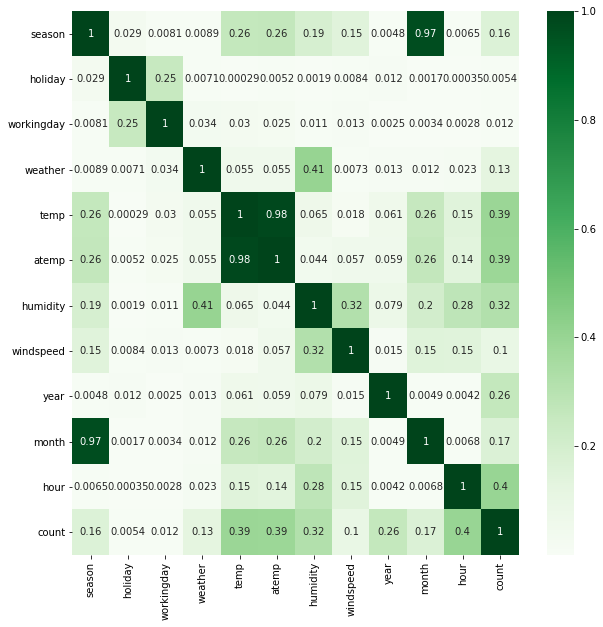

In [44]:
plt.figure(figsize = (10,10))
sns.heatmap(abs(data.corr()),annot = True,cmap = "Greens")

#### 다중공선성이 있는 것을 확인 할 수 있다.
- season, month
- temp, atemp

#### 나중에 pca 또는 column 삭제를 고려할 수 있다.

　
 　
  　
# 3. 전처리

In [45]:
X = data.drop(['count'],axis = 1)
y = data['count']
test = copy.copy(test)

## (1) 기본 데이터
- X_1 : 기본데이터 사용 
- y_1 : log화 시킨 값

In [46]:
X_1 = data.drop(['count'],axis = 1)
y_1 = np.log1p(y)
X_test_1 = copy.copy(test)

## (2) 시간데이터 범주화
- X_2 : 시간데이터 범주화
- y_2 : log화 시킨 값

Text(0, 0.5, 'count')

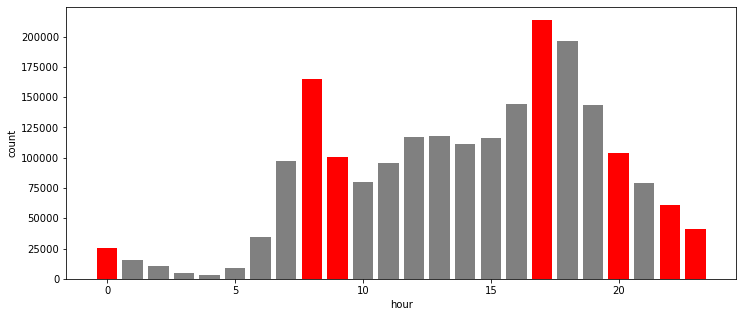

In [47]:
temp1 = pd.DataFrame(data['count'].groupby(data['hour']).sum())

# x값, y값
y = temp1['count'].unique().tolist()
x = temp1.index.tolist()

colors = ['grey'] * 23
for i in range(len(colors)):
    if i == 0 or i == 8 or i == 9 or i ==17 or i == 20 or i == 22 or i == 23:
        colors[i] = 'red'

plt.figure(figsize=(12, 5))

plt.bar(x,y,color = colors)
plt.xlabel('hour')
plt.ylabel('count')

In [48]:
bins = [-1,7,8,9,17,20,22,23]

cuts = pd.cut(data['hour'], bins,labels = [0,1,2,3,4,5,6])
data['hour'] = cuts

bins = [-1,7,8,9,17,20,22,23]

cuts = pd.cut(test['hour'], bins,labels = [0,1,2,3,4,5,6])
test['hour'] = cuts

In [49]:
temp = pd.DataFrame(data['count'].groupby([data['year'],data['month']]).sum())

<AxesSubplot:xlabel='year,month'>

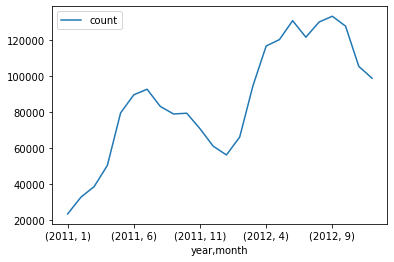

In [50]:
temp.plot()

In [51]:
temp = data[['month']]
temp_test = test[['month']]

temp_2011 = temp.iloc[temp[data['year'] == 2011].index]
temp_2012 = temp.iloc[temp[data['year'] == 2012].index]

temp_test_2011 = temp_test.iloc[temp_test[test['year'] == 2011].index]
temp_test_2012 = temp_test.iloc[temp_test[test['year'] == 2012].index]

temp_2012 = temp_2012 + 12
temp_test_2012 = temp_test_2012 + 12

temp = pd.concat([temp_2011,temp_2012], axis = 0)
temp_test = pd.concat([temp_test_2011, temp_test_2012], axis = 0)

data['month'] = temp
test['month'] = temp_test

In [52]:
bins = [-1,3,6,9,12,15,18,21,24]

cuts = pd.cut(test['month'], bins,labels = [0,1,2,3,4,5,6,7])
test['month'] = cuts

bins = [-1,3,6,9,12,15,18,21,24]

cuts = pd.cut(data['month'], bins,labels = [0,1,2,3,4,5,6,7])
data['month'] = cuts

In [53]:
X_2 = data.drop(['count'], axis = 1)
y_2 = np.log1p(data['count'])
X_test_2 = copy.copy(test)

## (3) 다중공선성 PCA 및 상관계수가 낮은 columns 제거

In [54]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()   
scaler = scaler.fit_transform(data[['temp','atemp','humidity','windspeed','year','hour']])

temp = pd.DataFrame(columns = ['temp','atemp','humidity','windspeed','year','hour'],data = scaler)
X_3 = pd.concat([X[['season','holiday','workingday','weather','month']],temp],axis = 1)
y_3 = np.log1p(data['count'])

scaler = StandardScaler()

X_test_3 = copy.copy(test)
scaler = scaler.fit_transform(test[['temp','atemp','humidity','windspeed','year','hour']])

temp = pd.DataFrame(columns = ['temp','atemp','humidity','windspeed','year','hour'],data = scaler)
X_test_3 = pd.concat([X_test_3[['season','holiday','workingday','weather','month']],temp],axis = 1)

In [55]:
X_3[['temp','atemp']].corr()

,temp,atemp
temp,1.000000,0.984948
atemp,0.984948,1.000000


In [56]:
X_3[['season','month']].corr()

,season,month
season,1.000000,0.971524
month,0.971524,1.000000


In [57]:
temp_atemp = X_3[['temp','atemp']].values
season_month = X_3[['season','month']].values

test_temp_atemp = X_test_3[['temp','atemp']].values
test_season_month = X_test_3[['season','month']].values

from sklearn.preprocessing import StandardScaler
temp_atemp_scaler = StandardScaler().fit_transform(temp_atemp)
season_month_scaler = StandardScaler().fit_transform(season_month)

test_temp_atemp_scaler = StandardScaler().fit_transform(test_temp_atemp)
test_season_month_scaler = StandardScaler().fit_transform(test_season_month)

from sklearn.decomposition import PCA

pca = PCA(n_components=1,random_state = 42)
temp_atemp = pca.fit_transform(temp_atemp_scaler)
season_month = pca.fit_transform(season_month_scaler)

test_temp_atemp = pca.fit_transform(test_temp_atemp_scaler)
test_season_month = pca.fit_transform(test_season_month_scaler)

X_3.drop(['season','month','temp','atemp'], axis = 1, inplace = True)
X_test_3.drop(['season','month','temp','atemp'], axis = 1, inplace = True)

X_3['pca_te_at'] = temp_atemp
X_3['pca_se_mo'] = season_month

X_test_3['pca_te_at'] = test_temp_atemp
X_test_3['pca_se_mo'] = test_temp_atemp

In [58]:
X_3.drop(['holiday'], axis = 1, inplace = True)
X_test_3.drop(['holiday'], axis = 1, inplace = True)

## (4) deeplearning

In [59]:
X_4 = data.drop(['count'], axis=1)
Y_4 = data['count']
X_test_4 = copy.copy(test)

In [60]:
X_4 = pd.get_dummies(X_4, columns=['year', 'month', 'hour', 'holiday','workingday','season','weather'])
y_4 = np.log1p(data['count'])
X_test_4 = pd.get_dummies(X_test_4, columns=['year', 'month', 'hour', 'holiday','workingday','season','weather'])

# 4. 모델링

## (1) 랜덤포레스트

> 전처리 1 데이터 사용

In [83]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_1,y_1,train_size = 0.7,random_state= 42)

In [64]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor()

param_grid = {'n_estimators' : [1000],
          'max_depth' : [10],
          'min_samples_leaf' : [3],
          'min_samples_split' : [5]
          }

grid_search = GridSearchCV(rf, param_grid=param_grid ,n_jobs=-1)
grid_search.fit(X_1, y_1)
print(grid_search.best_params_)

{'max_depth': 10, 'min_samples_leaf': 3, 'min_samples_split': 5, 'n_estimators': 1000}


In [65]:
RF_best = grid_search.best_estimator_
pred = RF_best.predict(X_test)

y_test = np.expm1(y_test)
pred = np.expm1(pred)

rmsle(y_test,pred)

RMSLE: 0.3428


0.34277912760058854

In [66]:
pred_test = RF_best.predict(X_test_1)

submission['count'] = np.expm1(pred_test)

submission.to_csv('./dataset/RF_preprocessing1.csv',index = False)

> 전처리 2 데이터 사용

In [67]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_2,y_2,train_size = 0.7,random_state= 42)

In [68]:
# {'max_depth': 10, 'min_samples_leaf': 3, 'min_samples_split': 10, 'n_estimators': 100}

rf = RandomForestRegressor()

param_grid = {'n_estimators' : [100],
          'max_depth' : [10],
          'min_samples_leaf' : [3],
          'min_samples_split' : [10]
          }

grid_search = GridSearchCV(rf, param_grid=param_grid ,n_jobs=-1)
grid_search.fit(X_train, y_train)
print(grid_search.best_params_)

{'max_depth': 10, 'min_samples_leaf': 3, 'min_samples_split': 10, 'n_estimators': 100}


In [69]:
RF_best = grid_search.best_estimator_
pred = RF_best.predict(X_test)

y_test = np.expm1(y_test)
pred = np.expm1(pred)

rmsle(y_test,pred)

RMSLE: 0.7960


0.7959605942243829

In [70]:
pred_test2 = RF_best.predict(X_test_2)

submission['count'] = np.expm1(pred_test2)

submission.to_csv('./dataset/RF_preprocessing2.csv',index = False)

> 전처리 3 데이터 사용

In [122]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_3,y_3,train_size = 0.7,random_state= 42)

In [123]:
# {'max_depth': 12, 'min_samples_leaf': 10, 'min_samples_split': 2, 'n_estimators': 1000}
rf = RandomForestRegressor()

param_grid = {'n_estimators' : [1000],
          'max_depth' : [12],
          'min_samples_leaf' : [10],
          'min_samples_split' : [2]
          }

grid_search = GridSearchCV(rf, param_grid=param_grid ,n_jobs=-1)
grid_search.fit(X_train, y_train)
print(grid_search.best_params_)

{'max_depth': 12, 'min_samples_leaf': 10, 'min_samples_split': 2, 'n_estimators': 1000}


In [124]:
RF_best = grid_search.best_estimator_
pred = RF_best.predict(X_test)

y_test = np.expm1(y_test)
pred = np.expm1(pred)

rmsle(y_test,pred)

RMSLE: 0.8002


0.8001508824690776

In [125]:
RF_best = grid_search.best_estimator_
pred = RF_best.predict(X_test_3)

pred_test3 = np.expm1(pred)

In [126]:
submission['count'] = pred_test3

submission.to_csv('./dataset/RF_preprocessing3.csv',index = False)

## (2) 딥러닝

> 전처리 4 데이터 사용

In [68]:
pred = model.predict(X_test)

In [70]:
y_test = np.expm1(y_test)
pred = np.expm1(pred).reshape(3266)

In [71]:
rmsle(y_test, pred)  

RMSLE: 0.8561


0.8561352206864428

In [237]:
pred = model.predict(X_test_4)

In [239]:
submission['count'] = np.expm1(pred)

submission.to_csv('./dataset/deepLearning_1.csv',index = False)

# 5. 결과값

## (1) 머신러닝

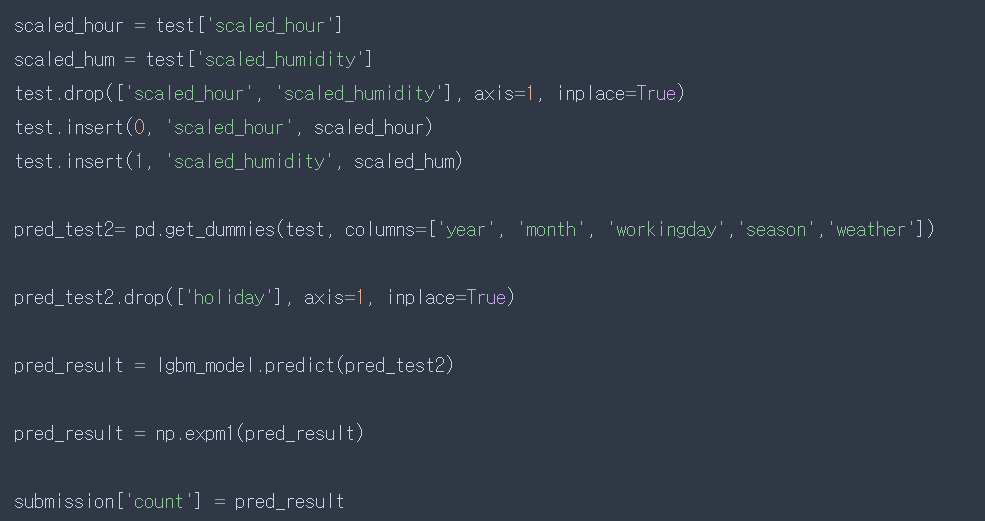

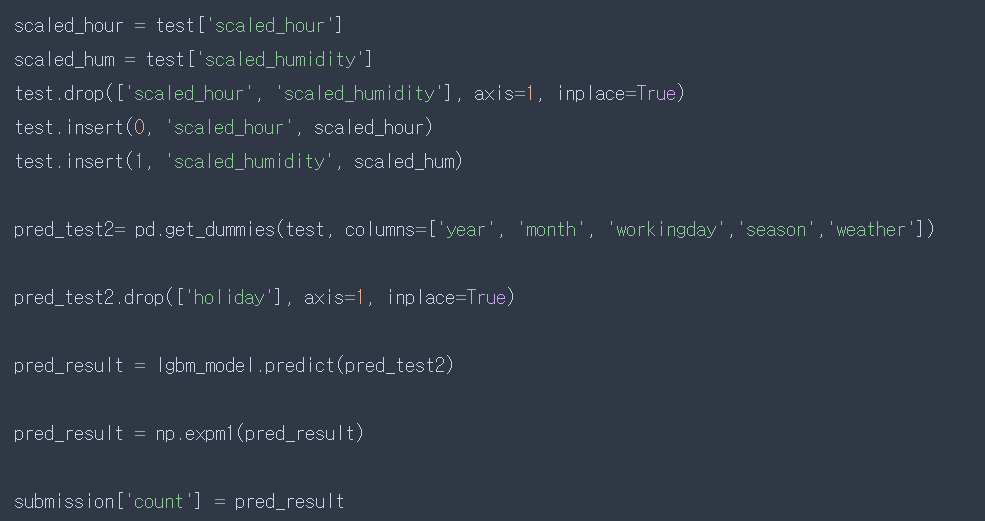

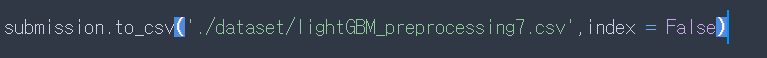

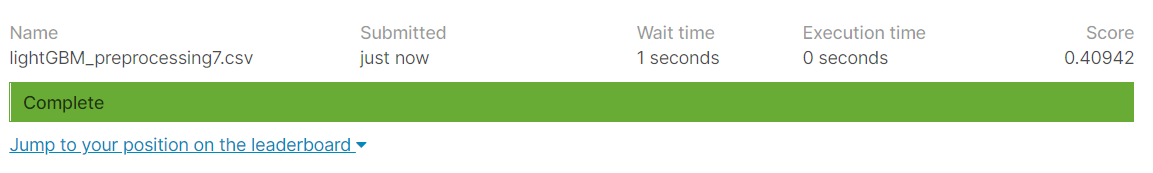

### 진영왕조실록 원문

오류값을 낮추기 위해서
표준화를 하려고 했는데
터무니 없는 컬럼을 표준화해서
많은 시간을 삽질함

heatmap을 통해
corr를 확인했을 때
count와 가장 높은 수치를 나타내는
hour와 가장 낮은 수치를 나타내는 humidity 값을
정규화하기로 함

해당 칼럼을
StandardScaler, RobustScaler, log scale 해서 
데이터 분포를
확인하기 위해 displot을 그려봄

기존 데이터와 분포가 비슷한 것,
데이터 분포 범위가'
좀 더 적은 것(overfitting이 덜 걸리기 때문이라함)
을 채택한 결과
standardScaler를 통해 정규화된 값을
x데이터로 이용함

values.reshape(-1,1)으로 정규화된 hour를
one hot encoding 한 탓에
'scaled_hour_-1.3797389998554084'
같은 난잡한 이름의 컬럼이 많이 생기게 됨

그때문에 submission에
머신러닝 모델이 예측한 count 값을 넣을 때
feature_names mismatch 오류가 발생해

오랜 시간 삽질함

## (2) 딥러닝

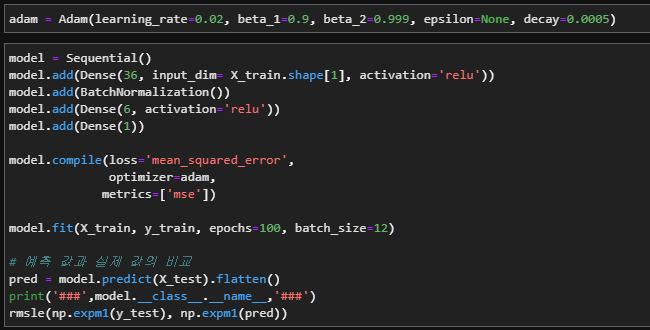

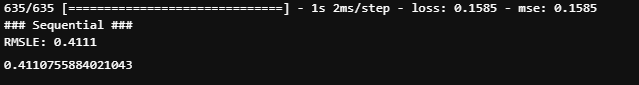

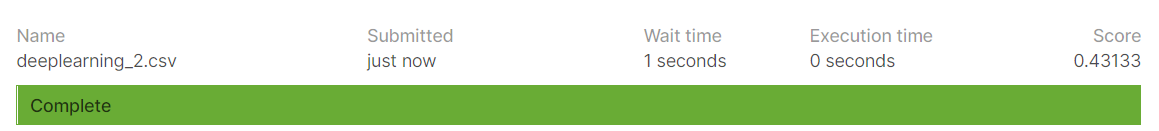